# The Annotated Transformer
The Transformer has been on a lot of people’s minds over the last year five years. This post presents an annotated version of the paper in the form of a line-by-line implementation. It reorders and deletes some sections from the original paper and adds comments throughout. This document itself is a working notebook, and should be a completely usable implementation. Code is available here.

## Prelims


Run the following 4 cells the first time setting this up in Colab.

In [1]:
#uninstall incompatible newer versions
!pip uninstall -y torch torchtext torchdata

Found existing installation: torch 2.9.0+cpu
Uninstalling torch-2.9.0+cpu:
  Successfully uninstalled torch-2.9.0+cpu
Found existing installation: torchdata 0.11.0
Uninstalling torchdata-0.11.0:
  Successfully uninstalled torchdata-0.11.0


In [2]:
#install compatible older versions
!pip install torch==2.2.2 torchtext==0.17.2 torchdata==0.7.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
#install remaining dependancies
!pip install pandas spacy altair jupytext GPUtil wandb

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=fde8418e820046e1a0ad2ee59a92b48def40e7aef5436917072d1fa17c4d26e0
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


In [4]:
#download spaCy model
!python -m spacy download en_core_web_sm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/usr/local/lib/python3.12/dist-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/usr/local/lib/python3.12/dist-packages/spacy/errors.py", line 3, in <module>
    from .compat import Literal
  File "/usr/local/lib/python3.12/dist-packages/spacy/compat.py", line 5, in <module>
    from thinc.

Restart Runtime Now

In [5]:
#get imports
import os
from os.path import exists
import math
import copy
import time
import warnings

import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
from torch.optim.lr_scheduler import LambdaLR

import pandas as pd
import altair as alt

from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets

import spacy
import GPUtil

import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

Note for later.

Change spacy.load("en") to spacy.load("en_core_web_sm")

In [6]:
# Some convenience helper functions used throughout the notebook


def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

## Background


The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.

## Part 1: Model architecture

### Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure (cite). Here, the encoder maps an input sequence of symbol representations (x1,...,xn)to a sequence of continuous representations z=(z1,...,zn). Given
z, the decoder then generates an output sequence (y1,...,ym) of symbols one element at a time. At each step the model is auto-regressive (cite), consuming the previously generated symbols as additional input when generating the next.

In [7]:
class EncoderDecoder(nn.Module):

  """
  a standard encoder-decoder architecture. base for this and many other models.
  """
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder= encoder
    self.decoder= decoder
    self.src_embed= src_embed
    self.tgt_embed= tgt_embed
    self.generator= generator

  def forward(self, src, tgt, src_mask, tgt_mask):
    "take in and process masked src and target sequences."
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


In [8]:
class Generator(nn.Module):
  "define standard linear + softmax generation step"

  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj= nn.Linear(d_model, vocab)

  def forward(self, x):
    return log_softmax(self.proj(x), dim= 1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

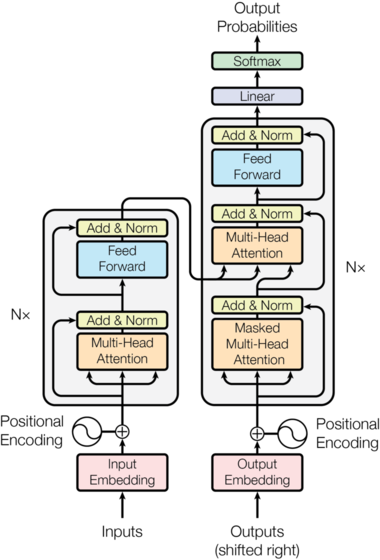

### Encoder and Decoder Stacks

####Encoder

The encoder is composed of stack N = 6 identical layers

In [9]:
def clones(module, N):
  "produce N identical layers"
  return nn.ModuleList([deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
  "Core encoder is a stack of N layers"

  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers= clones(layer, N)
    self.norm= LayerNorm(layer.size)

  def forward(self, x, mask):
    "Pass the input (and mask) through each layer in turn"
    for layer in self.layers:
      x= layer(x, mask)
    return self.norm(x)

We employ a residual connection (cite) around each of the two sub-layers, followed by layer normalization (cite).

In [ ]:
class LayerNorm(nn.Module):
  "construct a layernorm module"

  def __init__(self, features, eps= 1e-6):
    super(LayerNorm, self).__init__()
    self.a_2= nn.Parameter(torch.ones(features))
    self.b_2= nn.Parameter(torch.zeros(features))
    self.eps= eps

  def forward(self, x):
    mean= x.mean(-1, keepdim= True)
    std= x.std(-1, keepdim= True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is LayerNorm(x+Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. We apply dropout (cite) to the output of each sub-layer, before it is added to the sub-layer input and normalized.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension d_model = 512


In [ ]:
class SublayerConnection(nn.Module):
  """
  a residual connection followed by a layer norm.
  note for code simplicity the norm is first as opposed to last
  """

  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm= LayerNorm(size)
    self.dropout= nn.Dropout(dropout)

  def forward(self, x ,sublayer):
    "apply residual connection to any sublayer with same size"
    return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
  "encoder is made up of self atttention and feed forward (defined below)"

  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn= self_attn
    self.feed_forward= feed_forward
    self.sublayer= clones(SublayerConnection(size, dropout), 2)
    self.size= size

  def forward(self, x, mask):
    "follow figure 1 (left) for connections)"

    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

#### Decoder

The decoder is also composed of N =6 identical layers

In [ ]:
class Decoder(nn.Module):
  "generic N layer decoder with masking"

  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers= clones(layer, N)
    self.norm= LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x= layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [ ]:
class DecoderLayer(nn.Module):
  "decoder is made of self-attn, src_attn, and feed forward (defined below)"

  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size= size
    self.self_attn= self_attn
    self.src_attn= src_attn
    self.feed_forward= feed_forward
    self.sublayer= clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    "follow figure 1 (right) for connections"
    m= memory
    x= self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x= self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

In [ ]:
def subsequent_mask(size):
  "mask out subsequent positions"

  attn_shape= (1, size, size)
  subsequent_mask= torch.triu(torch.ones(attn_shape), diagonal= 1).to(
      torch.bool
      )
  return subsequent_mask == 0

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

In [ ]:
def example_mask():
  LS_data= pd.concat(
      [
          pd.Dataframe(
              {
                  "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                  "Window": y,
                  "Masking": x,
              }
          )
          for y in range(20)
          for x in range(20)
      ]
  )

  return (
      alt.Chart(LS_data)
      .mark_rect()
      .properties(height= 250, width= 250)
      .encode(
          alt.X("Window:0"),
          alt.Y("Masking:0"),
          alt.Color("Subsequent Mask: Q", scale= alt.Scale(scheme= "virdis")),
      )
      .interactive()
  )

show_example(example_mask)

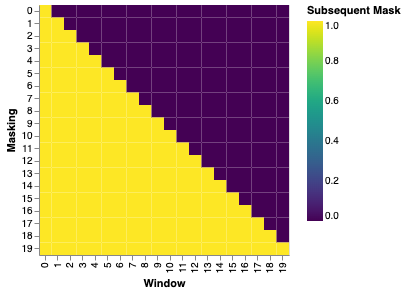

#### Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension d_k, and values of dimension d_v. We compute the dot products of the query with all keys, divide each by sqrt(d_k), and apply a softmax function to obtain the weights on the values.

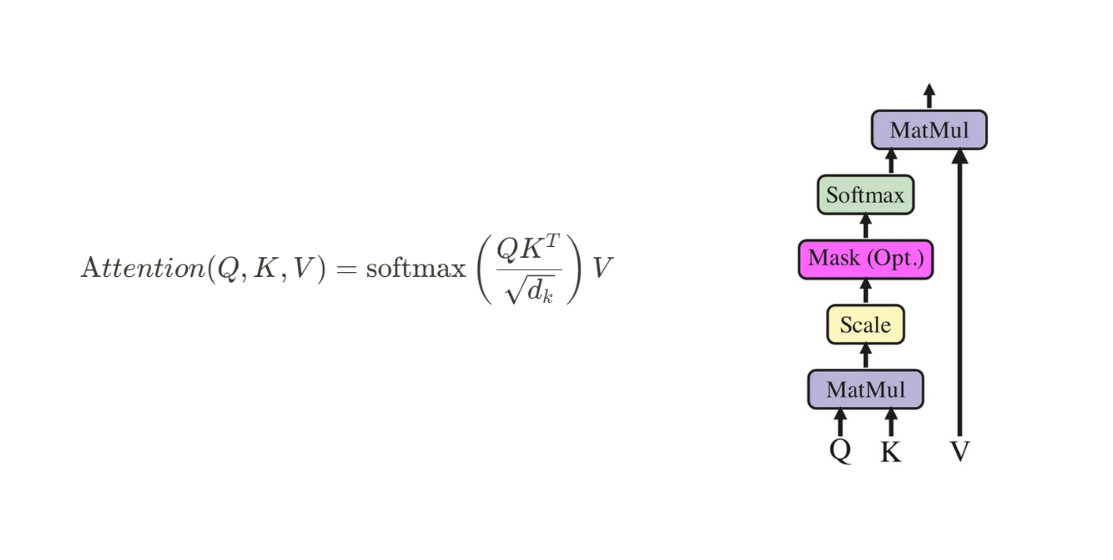

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices
K and V. We compute the matrix of outputs as:

In [ ]:
def attention(query, key, value, mask= None, dropout= None):
  "compute sclaed dot product attention"

  d_k= query.size(-1)
  scores= torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

  if mask is not None:
    scores= scores.masked_fill( mask == 0, -1e9)

  p_attn= scores.softmax(dim=-1)

  if dropout is not None:
    p_attn= dropout(p_attn)

  return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention (cite), and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of 1/sqrt(d_k). Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of d_k the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of d_k. We suspect that for large values of d_k, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients (To illustrate why the dot products get large, assume that the components of q and K are independent random variables with mean 0 and variance 1.  Then their dot product, has mean 0 and variance d_k). To counteract this effect, we scale the dot products by 1/sqrt(d_k).


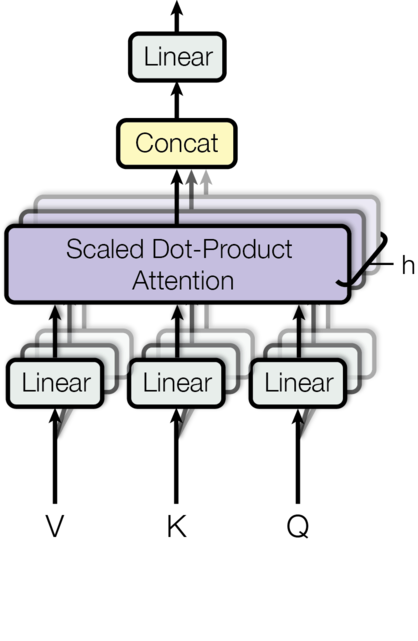

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

***formula not imported***

In this work we employ h=8 parallel attention layers, or heads. For each of these we use d_k= d_v = d_model / h= 64 Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, h, d_model, dropout= 0.1):
  "take in model size and number of heads."

  super(MultiHeadAttention, self).__init__()

  assert d_model % h == 0
  #we assume d_v always equals d_k
  self.d_k= d_model // h
  self.h= h
  self.linears= clones(nn.Linear(d_model, d_model), 4)
  self.attn= None
  self.dropout= nn.Dropout(p= dropout)

  def forward(self, query, key, value, mask= None):
    "Implements Figure 2"

    if mask is not None:
      #same mask ap[plied to all h heads
      mask= mask.unsqueeze(1)

    nbatches = query.size(0)

    # 1) do all the linear projections in batch from d_model => h x d_k
    query, key, value = [
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for lin, x in zip(self.linears, (query, key, value))
    ]

    # 2) apply attention on all the projected vectors in batch.
    x, self.attn= attention(
        query, key, value, mask= mask, dropout= self.dropout
    )

    # 3) concat using a vieww and apply a final linear layer
    x= (
        x.transpose(1,2)
        .contiguous()
        .view(nbatches, -1, self.h * self.d_k)
    )

    del query
    del key
    del value
    return self.linears[-1](x)

#### Application of attention in our model
The Transformer uses multi-head attention in three different ways:

1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as (cite).

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to illegal connections.

### Position wise feed forward networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is
d_model=512 and the inner-layer has dimensionality D_FF =2048.


In [ ]:
class PositionwiseFeedForward(nn.Module):
  "Implements FFN equation."

  def __init__(self, d_model, d_ff, dropout= 0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1= Linear(d_model, d_ff)
    self.w_2= Linear(d_ff, d_model)
    self.dropout= nn.Dropout(dropout)

    def forward(self, x):
      return self.w_2(self.dropout(self.w_1(x).relu()))

### Embeddings and Softmax

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension d_model. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to (cite). In the embedding layers, we multiply those weights by sqrt(d_model)

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embeddings, self).__init__()
    self.lut= nn.Embedding(vocab, d_model)
    self.d_model= d_model

def forward(self, x):
  return self.lut(x) * math.sqrt(self.d_model)


### Positional Emcoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension d_model as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed (cite).

In this work, we use sine and cosine functions of different frequencies:

where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from
2π to 10000. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PE_(pos+k)  can be represented as a linear function of PE_pos.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of P_drop = 0.1.

In [ ]:
class PositionalEncoding(nn.Module):
  "implement the PE function"

  def __init__(self, d_model, dropout, max_len= 5000):
    super(PositionalEncoding, self).__init__()
    self.dropout= nn.Dropout(p= dropout)

    #compute the positional encodings once in log space
    pe= torch.zeros(max_len, d_model)
    position= torch.arange(0, max_length).unsqueeze(1)
    div_term= torch.exp(
        torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)
    self.register_buffer("pe", pe)

  def forward(self, x):
    x= x + self.pe[:, : x.size(1)].requires_grad_(False)
    return self.dropout(x)

Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.

In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

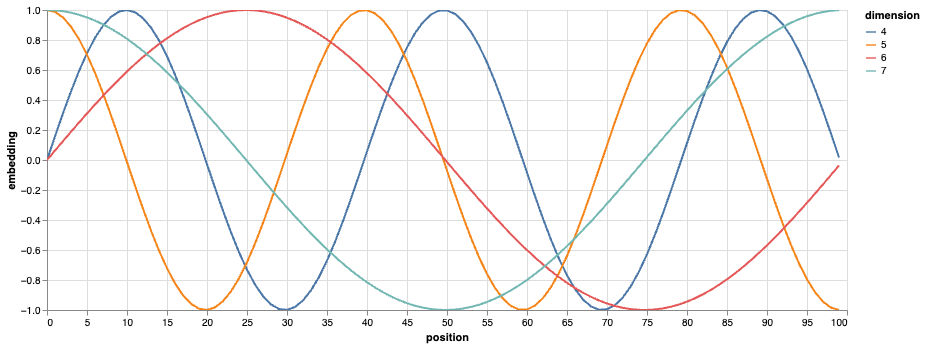

We also experimented with using learned positional embeddings (cite) instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

### Full Model

Here we define a function from hyperparameters to a full model.



In [ ]:
def make_model(
    src_vocab, tgt_vocab, N= 6, d_model= 512, d_ff= 2048, h= 8, dropout= 0.1
):

  "helper: construct a model from hyperparameters"

  c= copy.deepcopy
  attn= MultiHeadAttention(h, d_model)
  ff= PositionwiseFeedForward(d_model, d_ff, dropout)
  position= PositionalEncoding(d_model, dropout)
  model= EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
      Generator(d_model, tgt_vocab),
  )

  # this was important from their code.
  #Initialize parameters with Glorot / fan_avg.

  for p in model.parameters():
    if p.dim() >1:
      nn.init.xavier_uniform_(p)
  return model

### Inference:

Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.

In [ ]:
def inference_test():
  test_model= make_model(11, 11, 2)
  test_model.eval()
  src= torch.LongTensor([[1, 3, 4, 5, 6, 7, 8, 9, 10]])
  src_mark= torch.ones(1, 1, 10)

  memory= test_model.encode(src, src_mask)
  ys= torch.zeros(1, 1).type_as(src)

  for i in range(9):
    out= test_model.decode(
        memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
    )
    prob= test_model.encode(src, src_mask)
    ys= torch.zeros(1, 1).type_as(src)

    for i in range(9):
      out = test_model.decode(
          memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
      )
      prob = test_model.generator(out[:, -1])
      _, next_word = torch.max(prob, dim=1)
      next_word = next_word.data[0]
      ys = torch.cat(
          [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
      )

  print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)